<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/bnpParibasAutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 27th July, 2021
# My folder: D:\data\OneDrive\Documents\bnp_paribas_insurance
#
# AutoML:
# Ref: https://evalml.alteryx.com/en/stable/demos/lead_scoring.html
#
# Kaggle 
#      /home/ashok/Documents/bnp_paribas_insurance/

## Problem

As a global specialist in personal insurance, BNP Paribas Cardif serves 90 million clients in 36 countries across Europe, Asia and Latin America.

In a world shaped by the emergence of new uses and lifestyles, everything is going faster and faster. When facing unexpected events, customers expect their insurer to support them as soon as possible. However, claims management may require different levels of check before a claim can be approved and a payment can be made. With the new practices and behaviors generated by the digital economy, this process needs adaptation thanks to data science to meet the new needs and expectations of customers.

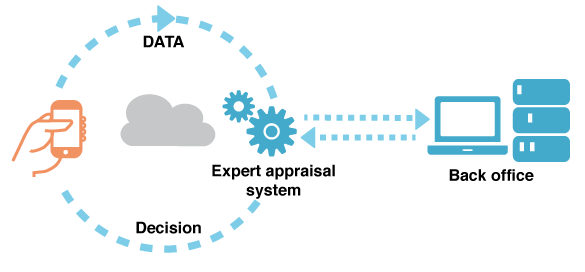

In this challenge, BNP Paribas Cardif is providing an anonymized database with two categories of claims:

You are challenged to predict the category of a claim based on features available early in the process, helping BNP Paribas Cardif accelerate its claims process and therefore provide a better service to its customers.

### Data and Task

You are provided with an anonymized dataset containing both categorical and numeric variables available when the claims were received by BNP Paribas Cardif. All string type variables are categorical. There are no ordinal variables.

The "target" column in the train set is the variable to predict. It is equal to 1 for claims suitable for an accelerated approval.

The task is to predict a probability ("PredictedProb") for each claim in the test set.

## Install packages

EvalML is an AutoML library that builds, optimizes, and evaluates machine learning pipelines using domain-specific objective functions.

Combined with Featuretools and Compose, EvalML can be used to create end-to-end supervised machine learning solutions.

In [ ]:
# Install evalml. Some of the packages installed are:
# imbalanced-learn, scikit-optimize, plotly, category-encoders,
# graphviz, lightgbm, shap, statsmodels, catboost, scikit-learn
# featuretools, matplotlib,nltk,xgboost, pmdarima (for the anagram of 'py' + 'arima')
# kaleido (blockchain) 

# Restart runtime after install

! pip install evalml
! pip install dask[dataframe] --upgrade 
! pip install ipywidgets

In [ ]:
!pip install --upgrade plotly
!pip install jupyter-dash

## Call libraries

In [71]:
# Call libraries
# 1.0 Data manipulation
import numpy as np
import pandas as pd

# 1.1 Auto Machine Learning
# conda install -c conda-forge evalml
import evalml
from evalml import AutoMLSearch
from evalml.pipelines.components import utils
from evalml.model_understanding.graphs import graph_confusion_matrix, graph_roc_curve
from evalml.data_checks import DefaultDataChecks

# 1.2 Woodwork makes it easy to manage additional
#      'data-typing' information for your data,
#        and, therefore, access only the data one needs
#         based on these additional data-types, called
#          logical types or semantic tags.
#           It is used by featuretools and evalml

import woodwork as ww  # Data typing management tool

# 1.3 Misc
import time, os

In [4]:
# 1.4
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [49]:
# 1.5 Suppress warnings
import warnings
warnings.filterwarnings("ignore")
evalml.warnings.filterwarnings('ignore')

## Dataset

Read data set from gdrive. Here we will deal only with train data

In [38]:
# 2.0 Connect to gdrive where data is stored
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [13]:
# 2.1 Where is my file:
filePath = "/gdrive/MyDrive/bnp_paribas"

# 2.2 Change working directory and read file
os.chdir(filePath)
#os.chdir("C:/Users/ashok/OneDrive/Documents/bnp_paribas_insurance")

# 2.3
X = pd.read_csv('train.csv.zip')

In [14]:
# 3.0
X.shape
y = X['target']
X=X.iloc[:,2:]
X.shape

(114321, 133)

(114321, 131)

In [ ]:
# 3.1
X.head()
y.head()

## Data Transformation
We will convert our data into Woodwork data structures. Doing so enables us to have more control over the types passed to and inferred by AutoML.

In [16]:
# 4.0 Get default Woodwork data structure
#     for this DataFrame by initializing it
#     with woordwork.init()

X.ww.init()

The first step is to make sure that our physical, logical and semantic types are correct.

> Physical Type – The actual data type of the incoming data. May also have storage information, as float64<br>
> Logical Type – This is how the DataFrame interprets the physical data type.<br>
> Semantic Tags – These are enhanced feature types that allow you to more thoroughly describe your data.<br>


EvalML utilizes the open-source Woodwork library to detect and specify how each feature should be treated, independent of its underlying physical data type. This means we can treat columns with the same physical data type differently. For example, we can specify that we want some columns that contain text to be treated as *categorical* columns, while we treat other columns with text as *natural language* columns, even if these columns have the same underlying object datatype. This differentiation allows us to clear up the ambiguity between features that may have the same underlying datatype in pandas (ie 'object'), but ultimately represent different types of data.


In [ ]:
# 4.1 Get X data type
X.ww

## Search for the best pipeline¶

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

EvalML natively supports one-hot encoding and imputation so the above NaN and categorical values will be taken care of.

In [18]:
# 5.0 partition data
X_train, X_holdout, y_train, y_holdout = evalml. \
                                         preprocessing. \
                                         split_data(
                                                     X, y,
                                                     problem_type='binary',
                                                     test_size=0.2,
                                                     random_seed=0
                                                    )


### Data Checks
See [here](https://evalml.alteryx.com/en/stable/user_guide/data_checks.html) for what all data checks are carried out 

Before calling AutoMLSearch.search, we should run some sanity checks on our data to ensure that the input data being passed will not run into some common issues before running a potentially time-consuming search. EvalML has various data checks that makes this easy. Each data check will return a collection of warnings and errors if it detects potential issues with the input data. This allows users to inspect their data to avoid confusing errors that may arise during the search process. You can learn about each of the data checks available through our data checks guide

Here, we will run the DefaultDataChecks class, which contains a series of data checks that are generally useful.

In [ ]:
# 5.1
data_checks = DefaultDataChecks("binary", "log loss binary")
data_checks.validate(X_train, y_train)

In EvalML, you can have generic objectives, such as RMSE, loglossbinary or loglossmulticlass and so on. OR, you can have business specific objectives.
To optimize the pipelines toward the specific business needs of this model, you can set your own assumptions for how much value is gained through true positives and the cost associated with false positives. These parameters are

> true_positive - dollar amount to be gained with a successful lead  
false_positive - dollar amount to be lost with an unsuccessful lead

## Start AutoMLSearch

In [ ]:
# 6.0
help(AutoMLSearch)

In [ ]:
# 6.1 What all estimators are possible
for component in utils.all_components():
  print(f"Estimator: {component.name}")

In [80]:
# 6.2 What all objectives can be set?
evalml.objectives.get_all_objective_names()

['expvariance',
 'maxerror',
 'medianae',
 'mse',
 'mae',
 'r2',
 'mean squared log error',
 'root mean squared log error',
 'root mean squared error',
 'mean absolute percentage error',
 'mcc multiclass',
 'log loss multiclass',
 'auc weighted',
 'auc macro',
 'auc micro',
 'recall weighted',
 'recall macro',
 'recall micro',
 'precision weighted',
 'precision macro',
 'precision micro',
 'f1 weighted',
 'f1 macro',
 'f1 micro',
 'balanced accuracy multiclass',
 'accuracy multiclass',
 'mcc binary',
 'log loss binary',
 'auc',
 'recall',
 'precision',
 'f1',
 'balanced accuracy binary',
 'accuracy binary',
 'sensitivity at low alert rates',
 'lead scoring',
 'fraud cost',
 'cost benefit matrix']

In [ ]:
# 6.3 Instantiate AutoMLSearch class 
automl = AutoMLSearch(
                      X_train=X_train,
                      y_train=y_train,
                      problem_type='binary',
                      objective='auc',       # Could be LogLossBinary 
                      additional_objectives=['f1'],
                      max_batches=3,
                      allowed_model_families=["catboost", "random_forest", "xgboost", "lightgbm"],
                    )

In [ ]:
# 6.4 
# Batch No1: All classifiers are cross-validated and AUC determined
# Batch No2: The best two of above are tested and auc determined
# Batch No3: The best one of the above is cross-validated repeatedly 

start = time.time()
# 6.4.1
automl.search(show_iteration_plot = True)

end = time.time()
print("Time taken: ", (end-start)/60)

## View rankings and select pipeline

Once the fitting process is done, we can see all of the pipelines that were searched, ranked by their score on the lead scoring objective we defined.

In [77]:
# 7.0 
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,XGBoost Classifier w/ Imputer + One Hot Encoder,3,0.747738,0.003051,0.744910,24.773773,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,2,LightGBM Classifier w/ Imputer + One Hot Encoder,2,0.747448,0.002153,0.745300,24.744823,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,4,CatBoost Classifier w/ Imputer,4,0.730028,0.003814,0.726428,23.002778,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,1,Random Forest Classifier w/ Imputer + One Hot ...,1,0.719827,0.002521,0.717440,21.982658,False,{'Imputer': {'categorical_impute_strategy': 'm...
14,0,Mode Baseline Binary Classification Pipeline,0,0.500000,0.000000,0.500000,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


## Best pipeline

To select the best pipeline we can call automl.best_pipeline.

In [78]:
# 7.1
best_pipeline = automl.best_pipeline
print(best_pipeline)

XGBoost Classifier w/ Imputer + One Hot Encoder


You can get more details about any pipeline, including how it performed on other objective functions by calling `.describe_pipeline()` and specifying the id of the pipeline.

In [ ]:
# 7.2
automl.describe_pipeline(automl.rankings.iloc[0]["id"])

## Evaluate on hold out data

Finally, since the best pipeline was trained on all of the training data, we evaluate it on the holdout dataset.

In [59]:
# 8.0
best_pipeline.score(
                     X_holdout,
                     y_holdout,
                     objectives=["auc", 'accuracy binary', 'f1', 'recall', 'precision'])

OrderedDict([('AUC', 0.7549287445294339),
             ('Accuracy Binary', 0.781806254100153),
             ('F1', 0.8721981709660065),
             ('Recall', 0.9781097385808676),
             ('Precision', 0.7869822485207101)])

In [82]:
# 8.2 Make predictions
best_pipeline.predict(X_holdout).head(3)
best_pipeline.predict_proba(X_holdout).head(3)

0    1
1    1
2    1
Name: target, dtype: int64

,0,1
0,0.160171,0.839829
1,0.221419,0.778581
2,0.143182,0.856818


## Further evaluation

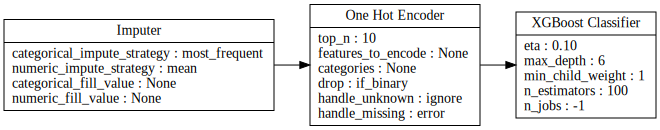

In [83]:
# 9.0 Visualizing best pipeline flow 
best_pipeline.graph()

In [65]:
# 9.1
best_pipeline.graph_feature_importance()

In [ ]:
# 9.2
best_pipeline.feature_importance

### Which features have been engineered

In [ ]:
# 9.3
best_pipeline.input_feature_names

### Our pipeline flow

### Save model for subsequent use

In [ ]:
# 10.0
best_pipeline.save("model.pkl")

In [ ]:
# 10.1
check_model=automl.load('model.pkl')

In [ ]:
# 10.2
check_model.predict_proba(X_holdout).to_dataframe()

### ROC graph and Confusion matrix

In [68]:
# 10.3 pipeline trained with log loss
y_pred = best_pipeline.predict(X_holdout)
graph_confusion_matrix(y_holdout, y_pred)

In [69]:
# 10.4
y_pred = best_pipeline.predict_proba(X_holdout)
graph_roc_curve(y_holdout, y_pred)

#### TO BE DONE

### Permutation Importance

We can also compute and plot the permutation importance of the pipeline.

In [ ]:
from evalml.model_understanding import graph_permutation_importance
graph_permutation_importance(best_pipeline, X_holdout, y_holdout, 'log loss binary')

In [88]:
from evalml.model_understanding.graphs import graph_partial_dependence
graph_partial_dependence(best_pipeline, X_holdout, features='v10', grid_resolution=5)

In [89]:
graph_partial_dependence(best_pipeline, X_holdout, features='v110', grid_resolution=5)

## Other projects using EvalML


> 1. Automated Text Classification with EvalML. [Predict spam messages](https://www.kdnuggets.com/2021/04/automated-text-classification-evalml.html) abd also see [here](https://evalml.alteryx.com/en/stable/demos/text_input.html)
> 2. BigMart dataset: [Predict Sales](https://www.vebuso.com/2021/05/exploring-evalml-automatically-build-optimize-and-evaluate-models/)

## autosklearn
Cannot handle NaN's in categorical features

In [ ]:
!pip install auto-sklearn

In [ ]:
import autosklearn.classification

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier()

In [ ]:
cls.fit(X_train,y_train)

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)

In [ ]:
########## I am done ##############